In [1]:
%matplotlib inline
# Switch to ''%matplotlib ipympl' for interactive plots
import warnings
import imp
import pickle
import lmfit
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt

# Styling
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [2]:
# Initialise wrapper and test datasets
wrapper_fpath = (r"..\mobius.py")
wr = imp.load_source('mobius', wrapper_fpath)
wr.initialize('..\..\Applications\SimplyC\SimplyC.dll')

# Calibration functions
calib_fpath = (r"..\mobius_calib_uncert_lmfit.py")
cu = imp.load_source('mobius_calib_uncert_lmfit', calib_fpath)

In [3]:
# Load dataset
dataset = wr.DataSet.setup_from_parameter_and_input_files('../../Applications/SimplyC/Langtjern/params_DOC_dissolution2.dat', 
                                                          '../../Applications/SimplyC/Langtjern/langtjerninputs2.dat')

In [4]:
# List of simulated and observed variables to investigate for Morsa
 comparisons = [
                #('Reach flow (daily mean, cumecs)', ['Inlet'], 'Discharge', []),
                ('Reach DOC concentration (volume weighted daily mean)', ['Inlet'], 'DOC', []),          
               ]

In [5]:
# Get parameter values defined in 'dataset'
param_df = cu.get_double_parameters_as_dataframe(dataset)
param_df

,name,unit,index,min_value,initial_value,max_value
0,Latitude,°C,(),-9.000000e+01,60.600000,9.000000e+01
1,PET multiplication factor,dimensionless,(),0.000000e+00,1.000000,2.000000e+00
2,Initial snow depth as water equivalent,mm,(),0.000000e+00,250.000000,5.000000e+04
3,Degree-day factor for snowmelt,mm/°C/day,(),0.000000e+00,2.000000,5.000000e+00
4,Proportion of precipitation that contributes t...,dimensionless,(),0.000000e+00,0.000000,1.000000e+00
5,Soil field capacity,mm,(),0.000000e+00,70.000000,1.000000e+03
6,Manning's coefficient,s/(m^1/3),(),1.200000e-02,0.040000,1.000000e-01
7,Catchment area,km^2,"(Inlet,)",0.000000e+00,0.800000,1.000000e+04
8,Reach length,m,"(Inlet,)",0.000000e+00,800.000000,1.000000e+07
9,Reach slope,m/m,"(Inlet,)",1.000000e-05,0.020000,3.000000e+00



Goodness of fit for Reach DOC concentration (volume weighted daily mean) [Inlet] vs DOC []:
Mean error (bias): -0.340178
Mean absolute error: 2.247310
Root mean square error: 3.042617
Nash-Sutcliffe coefficient: 0.091041
Number of observations: 1072



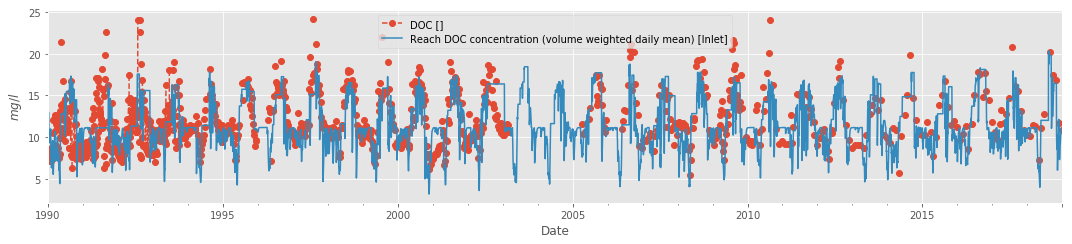

In [6]:
# Plot results from manual calibration
dataset.run_model()
cu.print_goodness_of_fit(dataset, comparisons)
cu.plot_objective(dataset, comparisons)

In [7]:
# Get params to be calibrated
vars = [
    #18, 19, 20, 22, 23
    #16, 17, 18, 20
    5, 16, 17, 18, 19,
]

calib_df = param_df.loc[vars].reset_index(drop=True)
calib_df

,name,unit,index,min_value,initial_value,max_value
0,Soil field capacity,mm,(),0.000000e+00,70.000000,1.000000e+03
1,Soil temperature DOC creation linear coefficient,mg/l/°C,(),-1.797693e+308,15.666191,1.797693e+308
2,Soil carbon solubility response to SO4 deposition,dimensionless,(),0.000000e+00,7.625472,2.000000e+01
3,Baseline Soil DOC creation rate,kg/km2/day,"(Forest and bog,)",0.000000e+00,300.000000,1.000000e+02
4,Baseline Soil DOC concentration,mg/l,"(Forest and bog,)",0.000000e+00,11.161266,1.000000e+02


In [8]:
# Add 'short_name' column for calibrating parameters
calib_df['short_name'] = [
    #'alphaPET',
    #'DDFmelt',
    #'fquick',
    #'c_m',
    #'Ts',
    #'sdst',
    #'stc',
    'Fc',
    'kT1',
    #'kT2',
    'kSO4',
    #'DOCmelt',
    #'cEq',
    'DOCc',
    'DOCb'
]

In [9]:
# Convert to LMFit parameter object
params = cu.parameter_df_to_lmfit(calib_df)


params['kT1'].min = -40.0
params['kT1'].max = 40.0
#params['kT2'].min = -0.1
#params['kT2'].max = 0.5

params['kSO4'].min = 0.0
params['kSO4'].max = 10.0

params['Fc'].max = 200.0
params['DOCc'].max = 300.0
params['DOCb'].min = 9.0
params['DOCb'].max = 14.0

#params['cEq'].min = 1.0
#params['cEq'].max = 1000.0

# Optionally refine prior ranges
#params['DDFmelt'].min = 0.05
#params['DDFmelt'].max = 4

#params['fquick'].min = 0.0
#params['fquick'].max = 0.2

#params['Ts'].max = 15

#params['T_g'].max = 200

#params['DOCsoilT'].max = 2.0

params

name,value,initial value,min,max,vary
Fc,70.0000000,70.0,0.00000000,200.000000,True
kT1,15.6661909,15.6661908849709,-40.0000000,40.0000000,True
kSO4,7.62547232,7.625472318372171,0.00000000,10.0000000,True
DOCc,100.000000,299.999999996492,0.00000000,300.000000,True
DOCb,11.1612655,11.1612655354171,9.00000000,14.0000000,True


In [10]:
%%time

dataset.set_parameter_uint('Timesteps', [], 6573) #make it run only for the calibration period

mi, res = cu.minimize_residuals(params, dataset, comparisons, method='nelder', norm=False, 
                                skip_timesteps=365)

print('Optimisation results:\n')
lmfit.report_fit(res)
print('\n\nOptimised parameter values:\n')
res.params.pretty_print(precision=3)

Optimisation results:

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 614
    # data points      = 769
    # variables        = 5
    chi-square         = 5805.22714
    reduced chi-square = 7.59846484
    Akaike info crit   = 1564.47433
    Bayesian info crit = 1587.69978
##  Warning: uncertainties could not be estimated:
[[Variables]]
    Fc:    139.867732 (init = 70)
    kT1:   11.1526005 (init = 15.66619)
    kSO4:  7.66664935 (init = 7.625472)
    DOCc:  271.558285 (init = 100)
    DOCb:  11.5879282 (init = 11.16127)


Optimised parameter values:

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
DOCb      11.6        9       14     None     True     None     None
DOCc       272        0      300     None     True     None     None
Fc         140        0      200     None     True     None     None
kSO4      7.67        0       10     None     True     None     None
kT1       11.2      -40       40     None     True     None 


Goodness of fit for Reach DOC concentration (volume weighted daily mean) [Inlet] vs DOC []:
Mean error (bias): -0.148238
Mean absolute error: 2.056957
Root mean square error: 2.780372
Nash-Sutcliffe coefficient: 0.240976
Number of observations: 1072



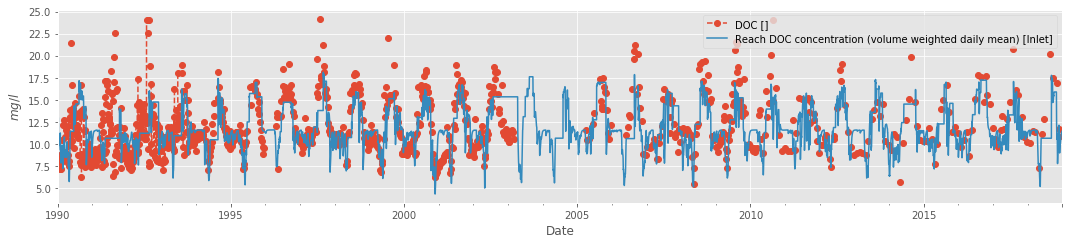

In [11]:
# Plot results from optimisation
cu.set_parameter_values(res.params, dataset)
#dataset.set_parameter_uint('Timesteps', [], 10591) #Set back so that the saved file has the right amount of timesteps

dataset.run_model()
cu.print_goodness_of_fit(dataset, comparisons)
cu.plot_objective(dataset, comparisons)
#dataset.write_parameters_to_file('structure6_auto.dat')

In [12]:
dataset.write_parameters_to_file('optimal_params_alt.dat')
res.params.pretty_print(columns=['value', 'min', 'max', 'vary'])

Name     Value      Min      Max     Vary
DOCb     11.59        9       14     True
DOCc     271.6        0      300     True
Fc       139.9        0      200     True
kSO4     7.667        0       10     True
kT1      11.15      -40       40     True


In [24]:
res.params.add(lmfit.Parameter('err_doc', value=0.5, min=0.05, max=3, user_data={}))
res.params.pretty_print(columns=['value', 'min', 'max', 'vary'])

Name         Value      Min      Max     Vary
DOCsbase     10.99        0       70     True
err_doc        0.5     0.05        3     True
kSO4        0.6389        0       10     True
kT1         0.2299        0        5     True
kT2        0.02835     -0.1      0.5     True


In [30]:
error_param_dict = {'DOC':  'err_doc'}

In [34]:
params['kT1'].min = 0.0
params['kT1'].max = 1.0
params['kT2'].min = -0.1
params['kT2'].max = 0.1

params['kSO4'].min = 0.0
params['kSO4'].max = 2.0

params['DOCsbase'].min = 5.0
params['DOCsbase'].max = 15.0

In [38]:
# emcee setup
nworkers = 8    # Number of cores/processes for parallelisation
ntemps = 1      # Number of temperatures for parallel tempering (use 1 for default ensemble sampler)
nsteps = 10000   # Number of steps per chain
nwalk = 100     # Number of chains/walkers
nburn = 1000     # Number of steps to discard as burn-in
thin = 1        # Keep only every 'thin' steps to reduce chain auto-correlation

# Chain initialisation
# 'uniform' => Chain starting locations sampled uniformly from prior
# 'optimum' => Chain starting locations sampled from a small Gaussian ball in vicinity of optimum
init_chains = 'optimum' #'uniform'  # Or 'optimum'. 

skip_timesteps = 365  # Number of time steps to skip before calulating fit

# Result file paths
result_path = r'results/mcmc_results.pkl'
chain_plot_path = r'results/chains.png'
corner_plot_path = r'results/corner.png'

In [39]:
settings_dict = {'params':res.params,
                 'error_param_dict':error_param_dict,
                 'comparisons':comparisons,
                 'skip_timesteps':skip_timesteps,
                 'nworkers':nworkers,
                 'ntemps':ntemps,
                 'nsteps':nsteps,
                 'nwalk':nwalk,
                 'nburn':nburn,
                 'thin':thin,
                 'init_chains':init_chains,
                 'result_path':result_path,
                 'chain_path':chain_plot_path,
                 'corner_path':corner_plot_path,                 
                }

with open('results/mcmc_settings.pkl', 'wb') as handle:
    pickle.dump(settings_dict, handle)

Time elapsed running emcee: 807.11 minutes.

Quantiles:
[(0.025, 0.21049105111075825), (0.5, 0.2310641313506225), (0.975, 0.2513922711190608)]
Quantiles:
[(0.025, 0.023893017392539663), (0.5, 0.027082570170143032), (0.975, 0.030328147895712972)]
Quantiles:
[(0.025, 0.4724474575458349), (0.5, 0.6541162671574597), (0.975, 0.836919607782272)]
Quantiles:
[(0.025, 10.7563805407539), (0.5, 11.224746586567976), (0.975, 11.698476866118279)]
Quantiles:
[(0.025, 0.14222350627819388), (0.5, 0.1495126463360741), (0.975, 0.15739835161949683)]


KeyError: 'map'

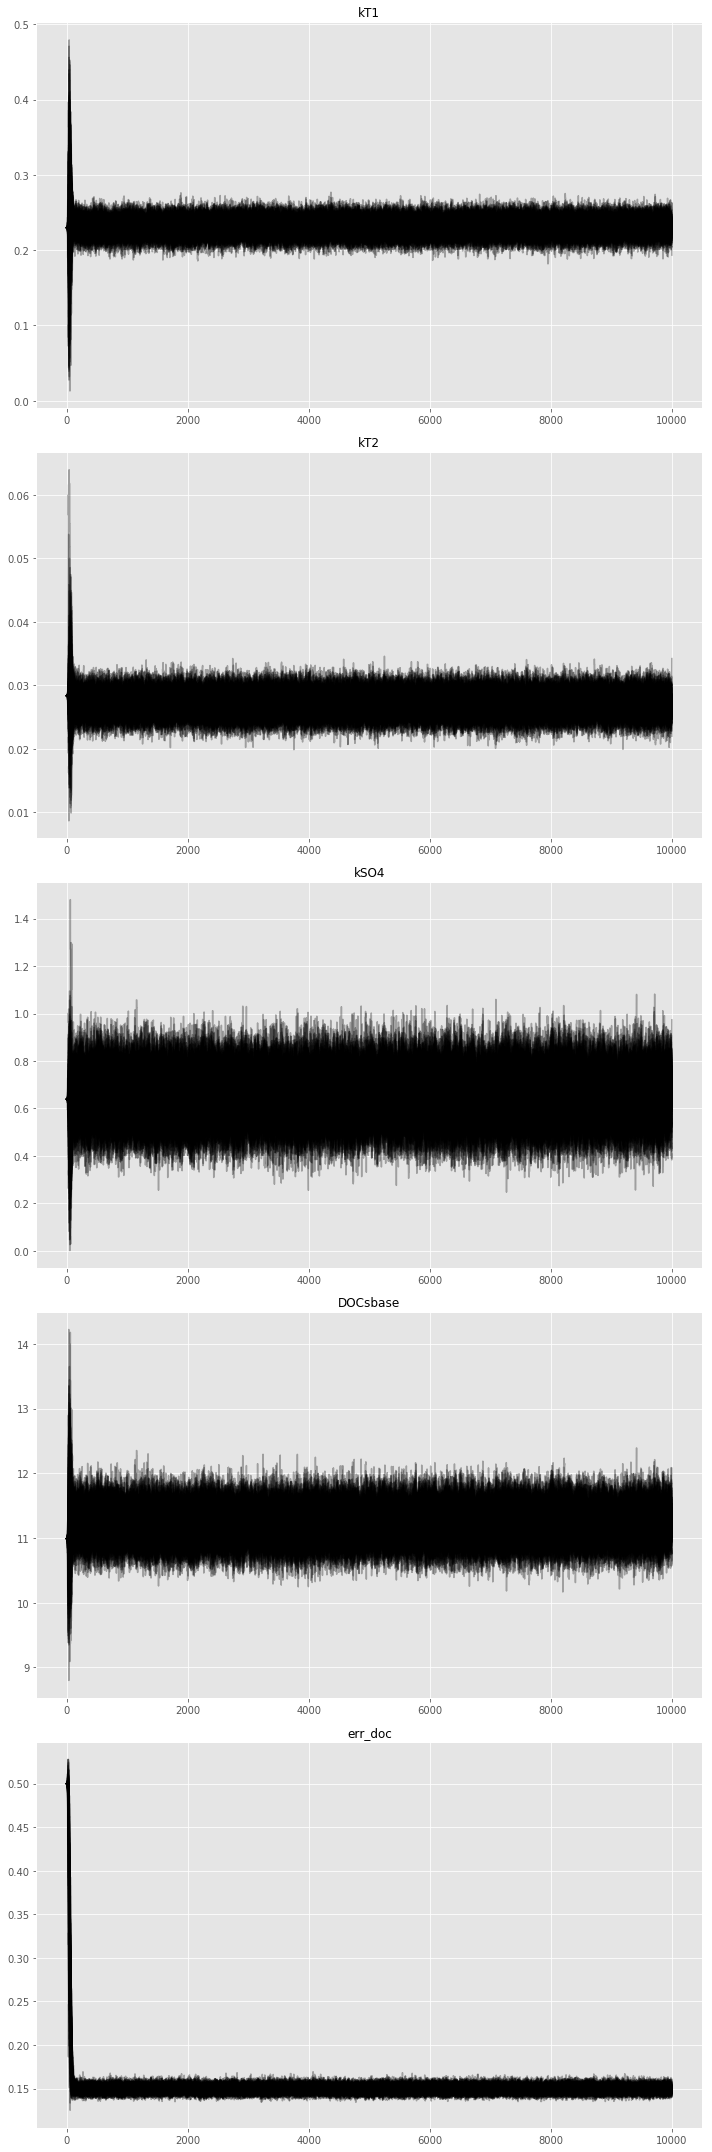

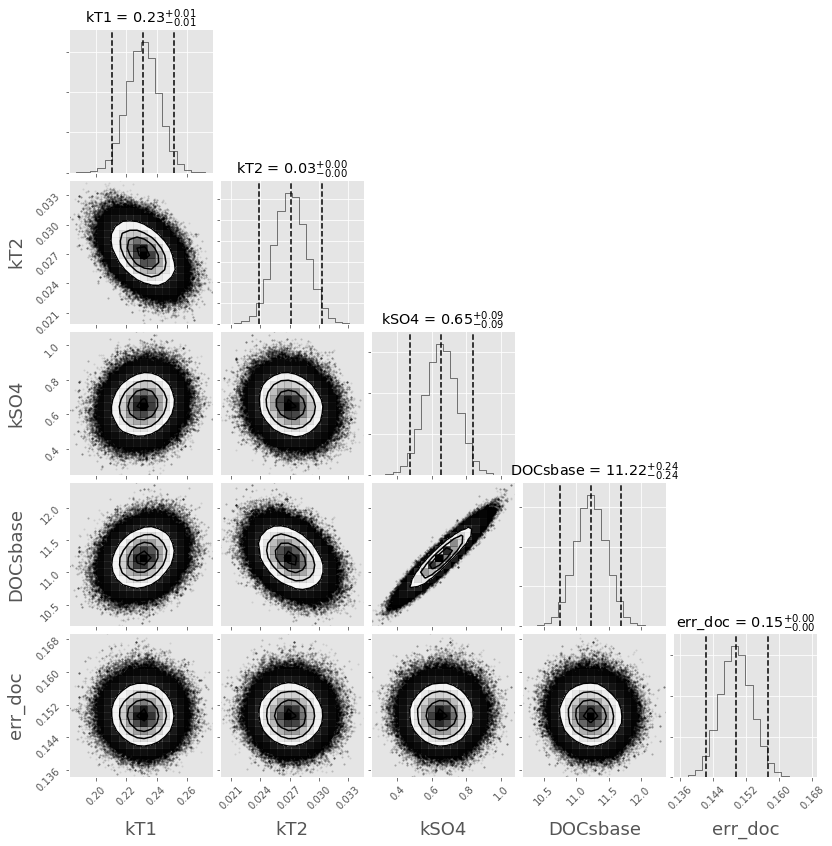

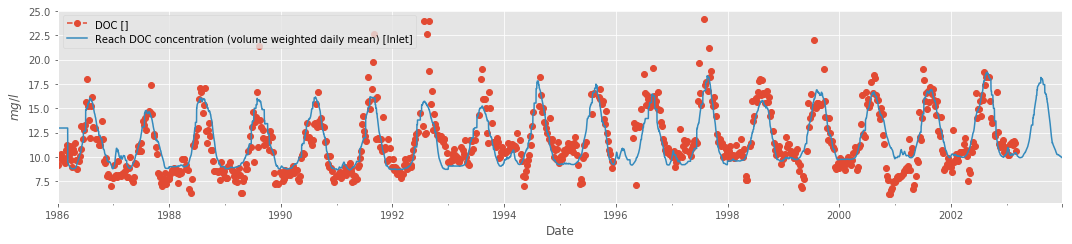

In [40]:
%run -i SimplyC_calib_uncert.py

In [ ]:
with open('results/mcmc_results.pkl', 'rb') as handle:
    result = pickle.load(handle)